In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("Online_Retail.csv")
print("Check the top 5 rows".center(80))
print(df.head())
print("Check how many rows and columns".center(80))
print(df.shape)   
print("Check Data Types".center(80))
print(df.info())  
#Check Duplicates & Missing Values
print("Check Duplicates & Missing Values".center(80))
print("Duplicates:", df.duplicated().sum())
print(df.isnull().sum())
                                                 #DATA CLEANING
#Removing Duplicates
df = df.drop_duplicates()

#Handle Missing Values
df = df.dropna(subset=["CustomerID"])

#Fix Datatypes[Invoice Date(String to DateTime),Customer ID(Float to Integer)]
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df["CustomerID"] = df["CustomerID"].astype(int)

#Removing Negative & Zero Quantities
df = df[df["Quantity"] > 0]
df = df[df["UnitPrice"] > 0]

#Creating TotalPrice Column
df["TotalSales"] = df["Quantity"] * df["UnitPrice"]

# Saving cleaned dataset to a new CSV file
df.to_csv("OnlineRetail_Cleaned.csv", index=False)
cleaned_df = pd.read_csv("OnlineRetail_Cleaned.csv")

# Check the top 5 rows
print("Check the top 5 rows of cleaned Dataset".center(80))
print(cleaned_df.head())


                              Check the top 5 rows                              
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

           InvoiceDate  UnitPrice  CustomerID         Country  
0  2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1  2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2  2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3  2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4  2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
                        Check how many rows and columns                         
(541909, 8)
         

Rows, Cols: (392692, 9)
Date range: 2010-12-01 08:26:00 → 2011-12-09 12:50:00
Unique Customers: 4338
Unique Orders: 18532
Unique Products: 3665
Countries: 37


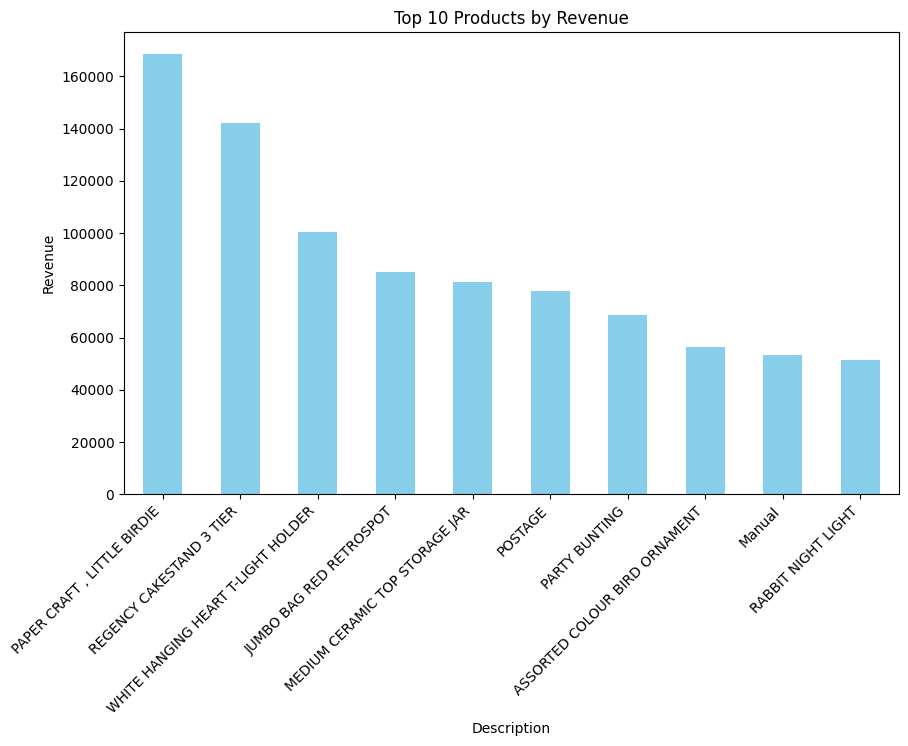

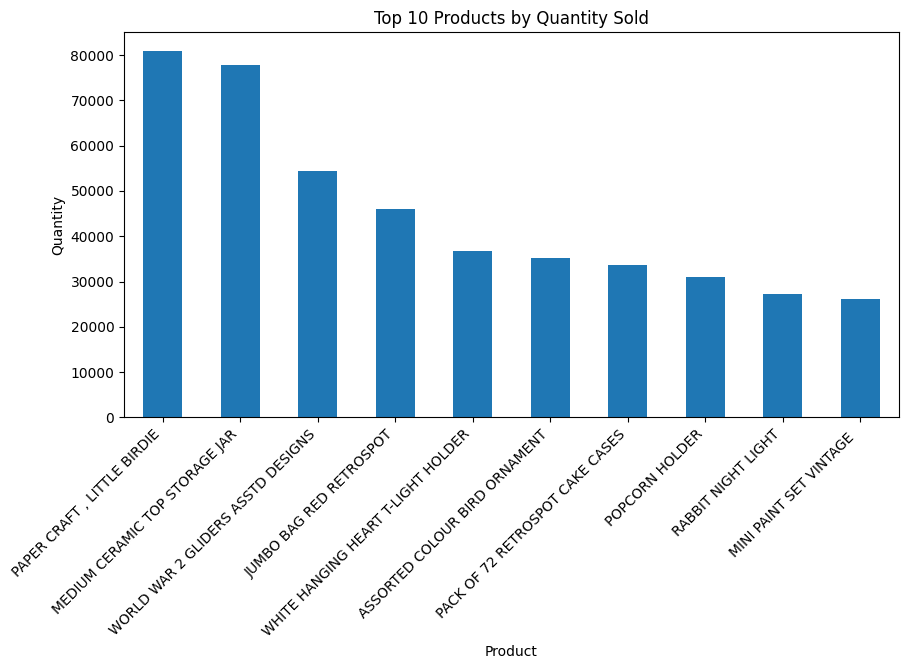

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'TotalSales', 'InvoiceMonth',
       'Year', 'Month', 'Week', 'Date'],
      dtype='object')


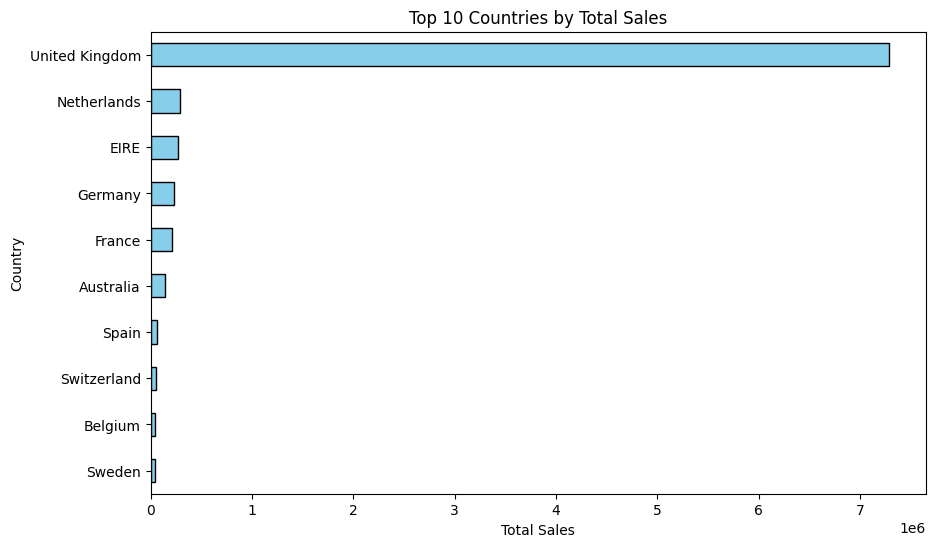

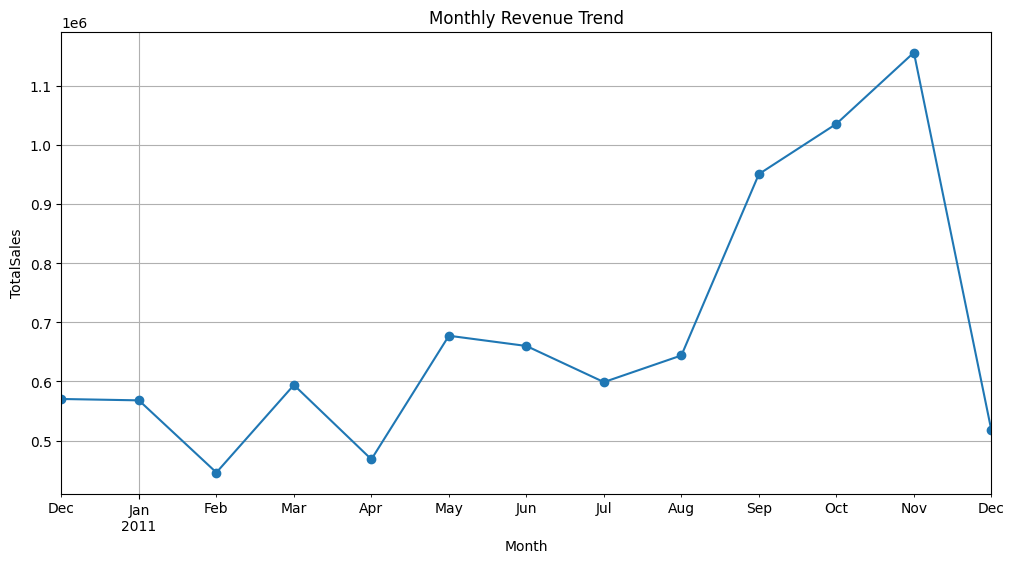

In [3]:
                                                          #EDA
#Basic KPIs
print("Rows, Cols:", df.shape)
print("Date range:", df["InvoiceDate"].min(), "→", df["InvoiceDate"].max())
print("Unique Customers:", df["CustomerID"].nunique())
print("Unique Orders:", df["InvoiceNo"].nunique())
print("Unique Products:", df["StockCode"].nunique())
print("Countries:", df["Country"].nunique())

#Time features(Make columns that will use later for time analysis)
df["InvoiceMonth"] = df["InvoiceDate"].values.astype('datetime64[M]')  # first day of month
df["Year"] = df["InvoiceDate"].dt.year
df["Month"] = df["InvoiceDate"].dt.month
df["Week"] = df["InvoiceDate"].dt.isocalendar().week.astype(int)
df["Date"] = df["InvoiceDate"].dt.date

#Business KPIs (overview)
overview = {
    "Total Revenue": df["TotalSales"].sum(),
    "Total Units": df["Quantity"].sum(),
    "Total Orders": df["InvoiceNo"].nunique(),
    "Unique Customers": df["CustomerID"].nunique(),
    "Unique Products": df["StockCode"].nunique(),
    "Average Order Value (AOV)": df.groupby("InvoiceNo")["TotalSales"].sum().mean(),
    "Avg Units per Order": df.groupby("InvoiceNo")["Quantity"].sum().mean()
}
pd.Series(overview)

#Monthly trend (Revenue, Units, Orders) + MoM%
monthly = (
    df.groupby("InvoiceMonth")
      .agg(Revenue=("TotalSales","sum"),
           Units=("Quantity","sum"),
           Orders=("InvoiceNo","nunique"))
      .reset_index()
      .sort_values("InvoiceMonth")
)

# Month-over-Month % for Revenue
monthly["Revenue_MoM_%"] = monthly["Revenue"].pct_change()*100
monthly["Units_MoM_%"]   = monthly["Units"].pct_change()*100
monthly["Orders_MoM_%"]  = monthly["Orders"].pct_change()*100
monthly.head(), monthly.tail()


# Recalculate revenue column
cleaned_df['Revenue'] = cleaned_df['Quantity'] * cleaned_df['UnitPrice']

# Top 10 products by Revenue
top_10_revenue = (
    cleaned_df.groupby('Description')['Revenue']
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

# Plot
plt.figure(figsize=(10,6))
top_10_revenue.plot(kind='bar', color='skyblue')
plt.title("Top 10 Products by Revenue")
plt.ylabel("Revenue")
plt.xticks(rotation=45, ha="right")
plt.savefig("Top 10 Products by Revenue.png", dpi=300, bbox_inches="tight")
plt.show()

#Top 10 Products by Quantity
top_products_qty = cleaned_df.groupby("Description")["Quantity"].sum().nlargest(10)

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
top_products_qty.plot(kind='bar')
plt.title("Top 10 Products by Quantity Sold")
plt.xlabel("Product")
plt.ylabel("Quantity")
plt.xticks(rotation=45, ha='right')
plt.savefig("Top 10 Products by Quantity Sold.png", dpi=300, bbox_inches="tight")
plt.show()

print(df.columns)

# Revenue by country
country_sales = df.groupby("Country")["TotalSales"].sum().sort_values(ascending=False).head(10)

# Plot Horizontal Bar Chart
plt.figure(figsize=(10,6))
country_sales.plot(kind="barh", color="skyblue", edgecolor="black")
plt.title("Top 10 Countries by Total Sales")
plt.xlabel("Total Sales")
plt.ylabel("Country")
plt.gca().invert_yaxis()  # So the highest value is on top
plt.savefig("Top 10 Countries by Total Sales.png", dpi=300, bbox_inches="tight")
plt.show()

# Time-Series Analysis of Revenue
# Extract month and year
df["YearMonth"] = df["InvoiceDate"].dt.to_period("M")

# Monthly revenue
monthly_revenue = df.groupby("YearMonth")["TotalSales"].sum()

# Plot
plt.figure(figsize=(12,6))
monthly_revenue.plot(marker='o')
plt.title("Monthly Revenue Trend")
plt.xlabel("Month")
plt.ylabel("TotalSales")
plt.grid(True)
plt.savefig("Monthly Revenue Trend.png", dpi=300, bbox_inches="tight")
plt.show()


2011-12-10 12:50:00
           Recency    Frequency       Monetary
count  4338.000000  4338.000000    4338.000000
mean     92.536422     4.272015    2048.688081
std     100.014169     7.697998    8985.230220
min       1.000000     1.000000       3.750000
25%      18.000000     1.000000     306.482500
50%      51.000000     2.000000     668.570000
75%     142.000000     5.000000    1660.597500
max     374.000000   209.000000  280206.020000


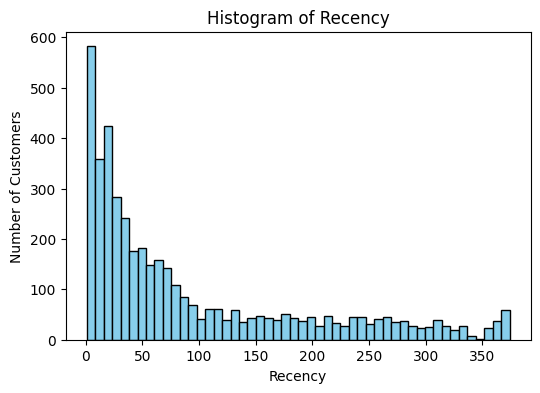

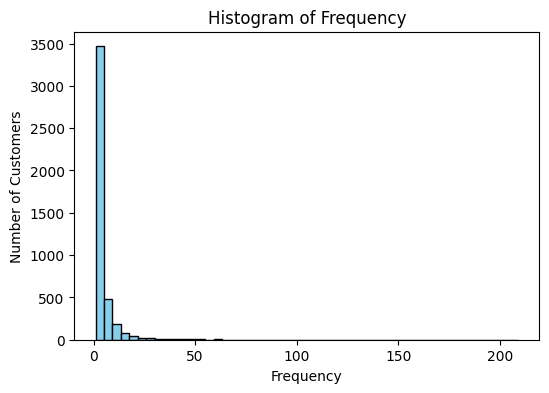

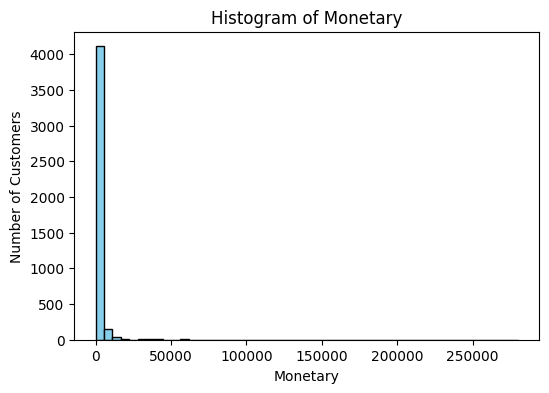

In [3]:
                                   #RFM Metrics (Recency, Frequency, Monetary)
#Setting a reference date
import datetime as dt
snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)
print(snapshot_date)

#Now create RFM 
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalSales': 'sum'
})
rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalSales': 'Monetary'
}, inplace=True)

rfm.head()
print(rfm.describe())

#Handling edge cases
rfm = rfm[rfm['Monetary'] > 0]

import matplotlib.pyplot as plt

#Histogram for RFM
columns = ['Recency', 'Frequency', 'Monetary']

for col in columns:
    plt.figure(figsize=(6,4))          # set figure size
    plt.hist(rfm[col], bins=50, color='skyblue', edgecolor='black')  
    plt.title(f'Histogram of {col}')   # chart title
    plt.xlabel(col)                    # x-axis label (values)
    plt.ylabel('Number of Customers')  # y-axis label (how many customers)
    plt.show()                         # show the chart



            Recency  Frequency  Monetary  R_Score  F_Score  M_Score  RFM_Sum  \
CustomerID                                                                     
12346           326          1  77183.60        1        2        5        8   
12347             2          7   4310.00        5        5        5       15   
12348            75          4   1797.24        2        4        4       10   
12349            19          1   1757.55        4        2        4       10   
12350           310          1    334.40        1        2        2        5   

                       Segment  
CustomerID                      
12346                  At Risk  
12347                Champions  
12348          Can’t Lose Them  
12349       Potential Loyalist  
12350                  At Risk  


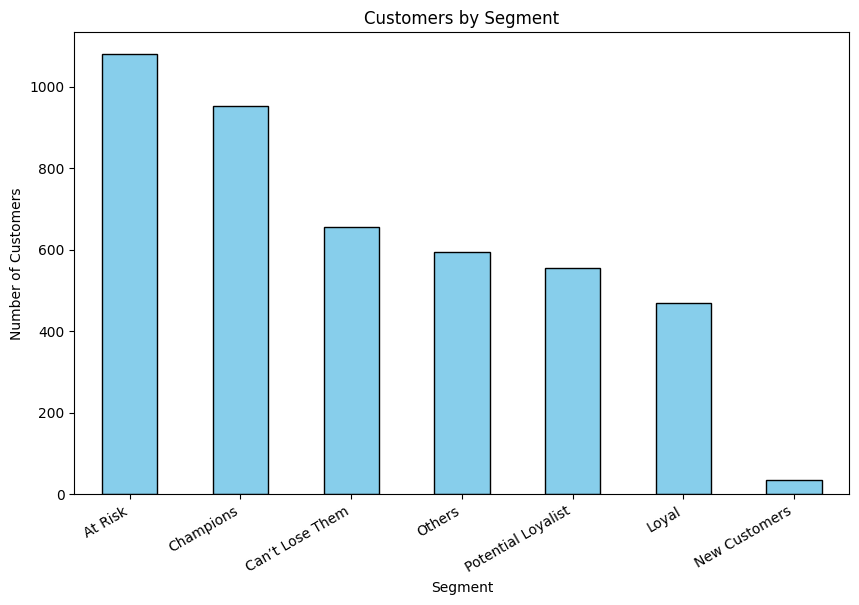

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'TotalSales', 'InvoiceMonth',
       'Year', 'Month', 'Week', 'Date', 'YearMonth'],
      dtype='object')


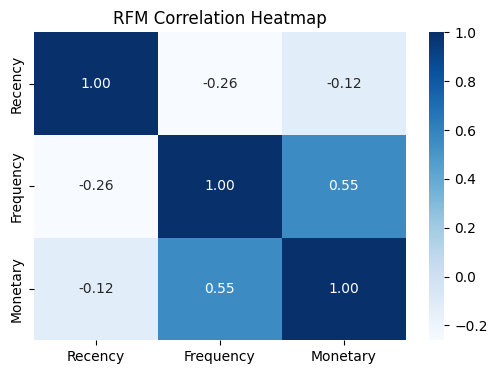

                            Insights / Summary Stats                            
Total Customers: 4338
Champions: 952 (21.9%)
At Risk: 1079 (24.9%)


In [4]:
                                                    #RFM Segmentation & Insights
# Rank-based scoring to avoid qcut errors
rfm_scored = rfm.copy()

# Recency: smaller is better → higher score
ranks_R = rfm_scored["Recency"].rank(method="first", ascending=True)
rfm_scored["R_Score"] = pd.qcut(ranks_R, 5, labels=[5,4,3,2,1]).astype(int)

# Frequency: higher is better
ranks_F = rfm_scored["Frequency"].rank(method="first", ascending=False)
rfm_scored["F_Score"] = pd.qcut(ranks_F, 5, labels=[5,4,3,2,1]).astype(int)

# Monetary: higher is better
ranks_M = rfm_scored["Monetary"].rank(method="first", ascending=False)
rfm_scored["M_Score"] = pd.qcut(ranks_M, 5, labels=[5,4,3,2,1]).astype(int)

# Add a combined score
rfm_scored["RFM_Sum"] = rfm_scored[["R_Score","F_Score","M_Score"]].sum(axis=1)

rfm_scored.head()

#Customer Segments
def label_segment(row):
    R, F, M = row["R_Score"], row["F_Score"], row["M_Score"]
    if R>=4 and F>=4 and M>=4:
        return "Champions"
    elif R>=4 and F>=3:
        return "Loyal"
    elif R>=3 and F>=2 and M>=3:
        return "Potential Loyalist"
    elif R==5 and F==1:
        return "New Customers"
    elif R<=2 and F>=3:
        return "Can’t Lose Them"
    elif R<=2 and F<=2:
        return "At Risk"
    else:
        return "Others"

rfm_scored["Segment"] = rfm_scored.apply(label_segment, axis=1)
print(rfm_scored.head())

#Bar Chart: Customers by Segment
seg_counts = rfm_scored["Segment"].value_counts().sort_values(ascending=False)

plt.figure(figsize=(10,6))
seg_counts.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Customers by Segment")
plt.xlabel("Segment")
plt.ylabel("Number of Customers")
plt.xticks(rotation=30, ha="right")
plt.savefig("Customers by Segment.png", dpi=300, bbox_inches="tight")
plt.show()

print(df.columns)

#Heatmap: Recency vs Frequency
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation heatmap for RFM
plt.figure(figsize=(6,4))
sns.heatmap(rfm[['Recency','Frequency','Monetary']].corr(), 
            annot=True, cmap="Blues", fmt=".2f")

plt.title("RFM Correlation Heatmap")
plt.show()

#Insights / Summary Stats
print("Insights / Summary Stats".center(80))
total_cust = len(rfm_scored)
champions = rfm_scored["Segment"].eq("Champions").sum()
at_risk   = rfm_scored["Segment"].eq("At Risk").sum()

print("Total Customers:", total_cust)
print("Champions:", champions, f"({champions/total_cust*100:.1f}%)")
print("At Risk:", at_risk, f"({at_risk/total_cust*100:.1f}%)")

#Finally Saving Segmented Data
rfm_scored.to_csv("RFM_Segmented.csv", index=False)
